In [1]:
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

%matplotlib inline  
from matplotlib import rcParams
rcParams['figure.figsize'] = (16, 100)

import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore") # Ignore all warnings
# warnings.filterwarnings("ignore", category=RRuntimeWarning) # Show some warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML

In [2]:
%%javascript
// Disable auto-scrolling
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
%%R

# My commonly used R imports

require('tidyverse')

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


Loading required package: tidyverse


In [4]:
%%R
# Load packages and prepare environment
library(tidyverse)
library(fixest)
library(ggplot2)


In [8]:
%%R
# Load the dataset
df <- read_csv("merged_election_hmda.csv")

# Create binary outcome


Rows: 148917888 Columns: 30
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (7): lei, state_code, derived_dwelling_category, property_value, county...
dbl (23): year, county_code, action_taken, loan_purpose, lien_status, loan_a...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [9]:
%%R
nrow(df)

[1] 148917888


In [10]:
%%R
str(df)

spc_tbl_ [148,917,888 × 30] (S3: spec_tbl_df/tbl_df/tbl/data.frame)
 $ year                             : num [1:148917888] 2015 2015 2015 2015 2015 ...
 $ lei                              : chr [1:148917888] NA NA NA NA ...
 $ state_code                       : chr [1:148917888] "6" "27" "41" "8" ...
 $ county_code                      : num [1:148917888] 6065 27147 41009 8014 6039 ...
 $ derived_dwelling_category        : chr [1:148917888] NA NA NA NA ...
 $ action_taken                     : num [1:148917888] 1 6 1 1 6 3 1 1 6 4 ...
 $ loan_purpose                     : num [1:148917888] 1 3 1 3 1 1 3 1 1 3 ...
 $ lien_status                      : num [1:148917888] 1 4 1 1 4 1 1 1 4 1 ...
 $ loan_amount                      : num [1:148917888] 265 151 148 152 161 ...
 $ property_value                   : chr [1:148917888] NA NA NA NA ...
 $ occupancy_type                   : num [1:148917888] 1 2 1 2 1 1 1 1 1 1 ...
 $ income                           : num [1:148917888] 91 NA 53 1

In [55]:
%%R
df_clean <- df %>%
  filter(
    loan_purpose == 1,
    derived_dwelling_category == "Single Family (1-4 Units):Site-Built",
    occupancy_type == 1,
    income > 0
  ) %>%
  mutate(
    approved = ifelse(action_taken %in% c(1, 2, 6), 1, 0),
    debt_to_income = loan_amount / income,
    race = case_when(
      `applicant_race-1` == 1 ~ "White",
      `applicant_race-1` == 3 ~ "Black",
      TRUE ~ NA_character_
    )
  ) %>%
  filter(!is.na(race), is.finite(debt_to_income))


In [56]:
%%R
df_clean <- df_clean %>%
  mutate(
    trump_county = ifelse(pct_gop > 0.5, 1, 0),
    biden_county = ifelse(pct_dem > 0.5, 1, 0)
  )


In [46]:
%%R
# Define the signature dates for anti-DEI laws per state
anti_dei_law_dates <- data.frame(
  state_code = c("ND", "OK", "TN", "IA", "ID", "FL", "MO", "MT", "NH", "OH"),
  law_date = as.Date(c(
    "2021-03-24",  # North Dakota
    "2021-05-05",  # Oklahoma
    "2021-05-25",  # Tennessee
    "2021-06-08",  # Iowa
    "2021-04-28",  # Idaho
    "2022-04-22",  # Florida
    "2023-05-12",  # Missouri
    "2023-04-19",  # Montana
    "2023-07-12",  # New Hampshire
    "2024-12-19"   # Ohio
  ))
)

In [48]:
%%R
# merge:
df_clean <- df_clean %>%
  left_join(anti_dei_law_dates, by = "state_code")


In [49]:
%%R
# Merge in law signature dates and create correct pre/post
df_clean <- df_clean %>%
  left_join(anti_dei_law_dates, by = "state_code") %>%
  mutate(
    activity_date = as.Date(paste0(year, "-01-01")),
    post_dei_law = ifelse(!is.na(law_date) & activity_date >= law_date, 1, 0),
    anti_dei_state = ifelse(!is.na(law_date), 1, 0)
  )


In [50]:
%%R
library(fixest)

# Only Black applicants for cleaner regression
df_black <- df_clean %>%
  filter(race == "Black", anti_dei_state == 1)

# Logistic model (feglm = logistic with fixed effects)
model_black_logit <- feglm(
  approved ~ post_dei_law * trump_county + income + loan_amount + debt_to_income |
    year + lei + county_code,
  data = df_black,
  family = "binomial"
)

summary(model_black_logit)


GLM estimation, family = binomial, Dep. Var.: approved
Observations: 89,374
Fixed-effects: year: 1,  lei: 789,  county_code: 347
Standard-errors: IID 
                  Estimate Std. Error   z value   Pr(>|z|)    
income          3.9274e-05 8.7838e-06   4.47119 7.7785e-06 ***
loan_amount     8.5200e-07 7.5700e-08  11.25896  < 2.2e-16 ***
debt_to_income -7.3428e-05 4.9622e-06 -14.79745  < 2.2e-16 ***
... 1 variable was removed because of collinearity (trump_county)
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
Log-Likelihood: -52,669.5   Adj. Pseudo R2: 0.033906
           BIC: 118,312.8     Squared Cor.: 0.066822
# Evaluations: lhs: 25 -- no convergence: Maximum number of iterations reached 


NOTES: 426,777 observations removed because of NA values (RHS: 426,777, Fixed-effects: 7,071).
       0/386/139 fixed-effects (1,245 observations) removed because of only 0 (or only 1) outcomes.
The variable 'trump_county' has been removed because of collinearity (see $collin.var).
In addition: Warning message:
Absence of convergence: Maximum number of iterations reached (25). Final deviance: 105,338.9. 


In [57]:
%%R
library(tidyverse)
library(fixest)

# Step 1: Start clean: Filter for Black applicants
df_black <- df_clean %>%
  filter(`applicant_race-1` == 3) %>%
  mutate(
    race = "Black",
    debt_to_income = loan_amount / income
  ) %>%
  filter(income > 0, is.finite(debt_to_income))

# Step 2: Merge Law Signature Dates
anti_dei_law_dates <- data.frame(
  state_code = c("ND", "OK", "TN", "IA", "ID", "FL", "MO", "MT", "NH", "OH"),
  law_date = as.Date(c(
    "2021-03-24", "2021-05-05", "2021-05-25", "2021-06-08", "2021-04-28",
    "2022-04-22", "2023-05-12", "2023-04-19", "2023-07-12", "2024-12-19"
  ))
)

df_black <- df_black %>%
  left_join(anti_dei_law_dates, by = "state_code") %>%
  mutate(
    activity_date = as.Date(paste0(year, "-01-01")),
    post_dei_law = ifelse(!is.na(law_date) & activity_date >= law_date, 1, 0),
    anti_dei_state = ifelse(!is.na(law_date), 1, 0)
  )

# Step 3: OPTIONAL (if you have Trump county data already merged):
# Already assumed you have 'trump_county' (1 = Trump majority county)

# Step 4: Run Logistic Regression - Black Only
model_black_logit <- feglm(
  approved ~ post_dei_law * anti_dei_state * trump_county +
    income + loan_amount + debt_to_income |
    year + lei + county_code,
  data = df_black,
  family = "binomial",
  control = list(maxit = 100, epsilon = 1e-8)
)

summary(model_black_logit)


GLM estimation, family = binomial, Dep. Var.: approved
Observations: 516,176
Fixed-effects: year: 1,  lei: 2,051,  county_code: 1,856
Standard-errors: IID 
                                Estimate   Std. Error   z value  Pr(>|z|)    
anti_dei_state               2.003591274 0.8692535325   2.30496  0.021169 *  
income                       0.000037014 0.0000041522   8.91424 < 2.2e-16 ***
loan_amount                  0.000000810 0.0000000273  29.71488 < 2.2e-16 ***
debt_to_income              -0.000096282 0.0000021598 -44.57875 < 2.2e-16 ***
anti_dei_state:trump_county -1.846446594 1.1375111087  -1.62323  0.104539    
... 1 variable was removed because of collinearity (trump_county)
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
Log-Likelihood: -298,268.2   Adj. Pseudo R2: 0.047863
           BIC:  647,982.5     Squared Cor.: 0.070828


NOTES: 2,525,943 observations removed because of NA values (RHS: 2,525,943, Fixed-effects: 145,963).
       0/977/514 fixed-effects (4,231 observations) removed because of only 0 (or only 1) outcomes.
The variable 'trump_county' has been removed because of collinearity (see $collin.var).
In addition: Warning message:
In fixest_env(fml = fml, data = data, family = famil...:
 feglm(fml = app...: control is not a valid argument for function feglm() 


In [ ]:
%%R
library(dplyr)
library(ggplot2)
library(tidyr)

# Focus: Only Anti-DEI states and post-2022 years

# List of Anti-DEI law states
anti_dei_states <- c("ND", "OK", "TN", "IA", "ID", "FL", "MO", "MT", "NH", "OH")

# Filter only Black applicants in Anti-DEI states post-2022
df_filtered <- df_clean %>%
  filter(state_code %in% anti_dei_states, year >= 2022) %>%
  filter(race == "Black") %>%
  mutate(fitted = predict(model_black_logit, newdata = ., type = "response"))

# Bin fitted probabilities and calculate approval rates
df_bins <- df_filtered %>%
  mutate(fitted_bin = cut(fitted, breaks = seq(0, 1, length.out = 21), include.lowest = TRUE)) %>%
  group_by(fitted_bin, post_dei_law) %>%
  summarise(
    approval_rate = mean(approved, na.rm = TRUE),
    n = n(),
    .groups = "drop"
  ) %>%
  pivot_wider(names_from = post_dei_law, values_from = approval_rate, names_prefix = "post_") %>%
  mutate(diff = post_1 - post_0)

# Plot where the Before/After difference is biggest
ggplot(df_bins, aes(x = fitted_bin, y = diff)) +
  geom_col(fill = "darkorange") +
  geom_hline(yintercept = 0, linetype = "dashed", color = "red") +
  labs(
    title = "Change in Mortgage Approval Rates After Anti-DEI Laws (Black Applicants, Anti-DEI States Only)",
    subtitle = "Positive bars = Higher approval rates after law passage",
    x = "Predicted Approval Probability Bin",
    y = "Approval Rate Change (After - Before)"
  ) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))


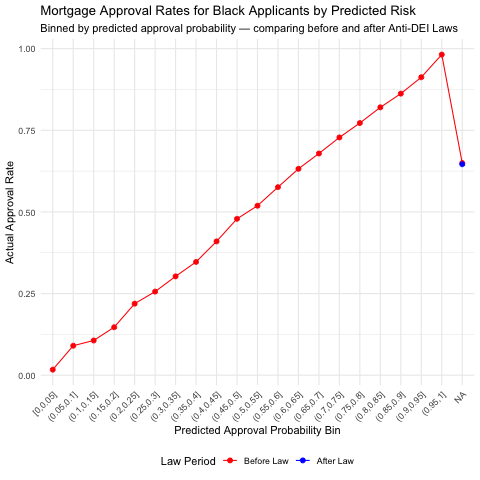

In [61]:
%%R
library(dplyr)
library(ggplot2)

# 1. Predict fitted values if not already
df_black$fitted <- predict(model_black_logit, newdata = df_black, type = "response")

# 2. Bin fitted probabilities into 20 equal-width bins
df_black_binned <- df_black %>%
  mutate(fitted_bin = cut(fitted, breaks = seq(0, 1, length.out = 21), include.lowest = TRUE)) %>%
  group_by(fitted_bin, post_dei_law) %>%
  summarise(
    approval_rate = mean(approved, na.rm = TRUE),
    n = n(), 
    .groups = "drop"
  )

# 3. Plot approval rates across predicted probability bins
ggplot(df_black_binned, aes(x = fitted_bin, y = approval_rate, group = as.factor(post_dei_law), color = as.factor(post_dei_law))) +
  geom_line(aes(group = as.factor(post_dei_law))) +
  geom_point(size = 2) +
  scale_color_manual(values = c("red", "blue"), labels = c("Before Law", "After Law")) +
  labs(
    title = "Mortgage Approval Rates for Black Applicants by Predicted Risk",
    subtitle = "Binned by predicted approval probability — comparing before and after Anti-DEI Laws",
    x = "Predicted Approval Probability Bin",
    y = "Actual Approval Rate",
    color = "Law Period"
  ) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1), legend.position = "bottom")


R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: Removed 20 rows containing missing values or values outside the scale range
(`geom_col()`). 



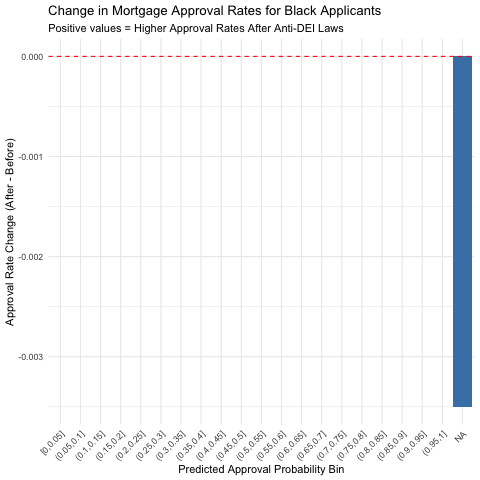

In [63]:
%%R
# Create a new dataset to calculate differences
df_diff <- df_black %>%
  mutate(fitted_bin = cut(fitted, breaks = seq(0, 1, length.out = 21), include.lowest = TRUE)) %>%
  group_by(fitted_bin, post_dei_law) %>%
  summarise(
    approval_rate = mean(approved, na.rm = TRUE),
    .groups = "drop"
  ) %>%
  pivot_wider(names_from = post_dei_law, values_from = approval_rate, names_prefix = "post_") %>%
  mutate(diff = post_1 - post_0)  # after - before

# Plot the differences
ggplot(df_diff, aes(x = fitted_bin, y = diff)) +
  geom_col(fill = "steelblue") +
  geom_hline(yintercept = 0, linetype = "dashed", color = "red") +
  labs(
    title = "Change in Mortgage Approval Rates for Black Applicants",
    subtitle = "Positive values = Higher Approval Rates After Anti-DEI Laws",
    x = "Predicted Approval Probability Bin",
    y = "Approval Rate Change (After - Before)"
  ) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))


In [ ]:
%%R
df_clean <- df_clean %>%
  filter(`applicant_race-1` %in% c(1, 3)) %>%  # 1 = White, 3 = Black
  mutate(
    race = ifelse(`applicant_race-1` == 3, "Black", "White"),
    debt_to_income = loan_amount / income
  ) %>%
  filter(income > 0, is.finite(debt_to_income))


In [26]:
%%R
model_black <- feols(
  approved ~ post_dei_law * anti_dei_state * black + income + loan_amount + debt_to_income |
    activity_year + lei + county_code,
  data = df_clean %>% filter(race == "Black")
)

NOTE: 146,056 observations removed because of NA values (RHS: 146,056).
The variable 'post_dei_law:anti_dei_state' has been removed because of collinearity (see $collin.var).


In [59]:
%%R
model_black <- feols(
  approved ~ post_dei_law * anti_dei_state * black + income + loan_amount + debt_to_income |
    activity_year + county_code,
  data = df_clean %>% filter(race == "Black")
)

NOTE: 146,056 observations removed because of NA values (RHS: 146,056).
The variables 'black', 'post_dei_law:anti_dei_state' and 'post_dei_law:anti_dei_state:black' have been removed because of collinearity (see $collin.var).


In [26]:
%%R
df_clean <- df_clean %>%
  mutate(
    trump_county = ifelse(pct_gop > 0.5, 1, 0)
  )
df_clean <- df_clean %>%
  mutate(
    black = ifelse(race == "Black", 1, 0)
  )

In [29]:
%%R
library(fixest)

# Make sure data is filtered for Black applicants
df_black <- df_clean %>% filter(race == "Black")

# Logistic regression with political context added
model_black_logit <- feglm(
  approved ~ post_dei_law * anti_dei_state * trump_county + income + loan_amount + debt_to_income |
    year + lei + county_code,
  data = df_black,
  family = "binomial"
)

# View summary
summary(model_black_logit)


GLM estimation, family = binomial, Dep. Var.: approved
Observations: 516,176
Fixed-effects: year: 1,  lei: 2,051,  county_code: 1,856
Standard-errors: IID 
                                Estimate   Std. Error   z value  Pr(>|z|)    
anti_dei_state               2.003591274 0.8692535325   2.30496  0.021169 *  
income                       0.000037014 0.0000041522   8.91424 < 2.2e-16 ***
loan_amount                  0.000000810 0.0000000273  29.71488 < 2.2e-16 ***
debt_to_income              -0.000096282 0.0000021598 -44.57875 < 2.2e-16 ***
anti_dei_state:trump_county -1.846446594 1.1375111087  -1.62323  0.104539    
... 1 variable was removed because of collinearity (trump_county)
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
Log-Likelihood: -298,268.2   Adj. Pseudo R2: 0.047863
           BIC:  647,982.5     Squared Cor.: 0.070828


NOTES: 2,525,943 observations removed because of NA values (RHS: 2,525,943, Fixed-effects: 145,963).
       0/977/514 fixed-effects (4,231 observations) removed because of only 0 (or only 1) outcomes.
The variable 'trump_county' has been removed because of collinearity (see $collin.var).


## black versus non-black 

In [32]:
%%R
df_clean <- df_clean %>%
  mutate(
    race_group = ifelse(`applicant_race-1` == 3, "Black", "Non-Black"),
    debt_to_income = loan_amount / income
  ) %>%
  filter(
    income > 0,
    is.finite(debt_to_income)
  )


In [35]:
%%R
model_black_nonblack_full <- feglm(
  approved ~ post_dei_law * anti_dei_state * trump_county * race_group +
    income * race_group +
    loan_amount * race_group +
    debt_to_income * race_group |
    year + lei + county_code,
  data = df_clean,
  family = "binomial"
)

summary(model_black_nonblack_full)


GLM estimation, family = binomial, Dep. Var.: approved
Observations: 563,011
Fixed-effects: year: 1,  lei: 2,213,  county_code: 2,186
Standard-errors: IID 
                                                    Estimate   Std. Error
anti_dei_state                                   1.992373533 0.8688959024
race_groupNon-Black                              0.106902428 0.0328319435
income                                           0.000036273 0.0000041423
loan_amount                                      0.000000780 0.0000000269
debt_to_income                                  -0.000096005 0.0000021534
anti_dei_state:trump_county                     -1.393976613 1.0695638193
anti_dei_state:race_groupNon-Black              -0.094680387 0.0501107289
trump_county:race_groupNon-Black                -0.023418705 0.0306622154
race_groupNon-Black:income                      -0.000014478 0.0000100738
race_groupNon-Black:loan_amount                 -0.000000559 0.0000000740
race_groupNon-Black:debt_to_in

NOTES: 2,765,804 observations removed because of NA values (RHS: 2,765,804, Fixed-effects: 160,313).
       0/1,025/504 fixed-effects (4,620 observations) removed because of only 0 (or only 1) outcomes.
The variable 'trump_county' has been removed because of collinearity (see $collin.var).


In [34]:
%%R
model_black_nonblack_logit <- feglm(
  approved ~ post_dei_law * anti_dei_state * trump_county * race_group +
    income * race_group + loan_amount * race_group + debt_to_income * race_group |
    year + lei + county_code,
  data = df_clean,
  family = "binomial"
)

summary(model_black_nonblack_logit)


GLM estimation, family = binomial, Dep. Var.: approved
Observations: 563,011
Fixed-effects: year: 1,  lei: 2,213,  county_code: 2,186
Standard-errors: IID 
                                                    Estimate   Std. Error
anti_dei_state                                   1.992373533 0.8688959024
race_groupNon-Black                              0.106902428 0.0328319435
income                                           0.000036273 0.0000041423
loan_amount                                      0.000000780 0.0000000269
debt_to_income                                  -0.000096005 0.0000021534
anti_dei_state:trump_county                     -1.393976613 1.0695638193
anti_dei_state:race_groupNon-Black              -0.094680387 0.0501107289
trump_county:race_groupNon-Black                -0.023418705 0.0306622154
race_groupNon-Black:income                      -0.000014478 0.0000100738
race_groupNon-Black:loan_amount                 -0.000000559 0.0000000740
race_groupNon-Black:debt_to_in

NOTES: 2,765,804 observations removed because of NA values (RHS: 2,765,804, Fixed-effects: 160,313).
       0/1,025/504 fixed-effects (4,620 observations) removed because of only 0 (or only 1) outcomes.
The variable 'trump_county' has been removed because of collinearity (see $collin.var).


In [41]:
%%R
approval_change_clean <- approval_change %>%
  filter(!is.na(change_in_approval))  # only keep states with valid approval change


In [42]:
%%R
approval_change %>% select(state_code, state_name, change_in_approval)


# A tibble: 61 × 3
   state_code state_name  change_in_approval
   <chr>      <chr>                    <dbl>
 1 AK         alaska                      NA
 2 AL         alabama                     NA
 3 AR         arkansas                    NA
 4 AZ         arizona                     NA
 5 CA         california                  NA
 6 CO         colorado                    NA
 7 CT         connecticut                 NA
 8 DC         <NA>                        NA
 9 DE         delaware                    NA
10 FL         florida                     NA
# ℹ 51 more rows
# ℹ Use `print(n = ...)` to see more rows


In addition: Warning message:
In geom_map(data = us_states, map = us_states, aes(x = long, y = lat,  :
  Ignoring unknown aesthetics: x and y


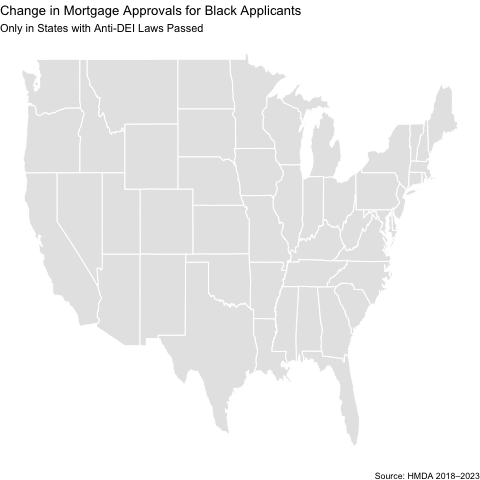

In [44]:
%%R
library(tidyverse)
library(maps)

# Step 1: Focus only on Anti-DEI states
anti_dei_states <- c("FL", "TN", "OK", "ND", "IA", "ID", "MO", "MT", "NH", "OH")

approval_summary <- df_clean %>%
  filter(race == "Black", state_code %in% anti_dei_states) %>%
  group_by(state_code, post_dei_law) %>%
  summarise(
    approval_rate = mean(approved, na.rm = TRUE),
    count = n(),
    .groups = "drop"
  )

approval_change <- approval_summary %>%
  pivot_wider(
    names_from = post_dei_law,
    values_from = approval_rate,
    names_prefix = "post_dei_"
  ) %>%
  filter(!is.na(post_dei_0) & !is.na(post_dei_1)) %>%
  mutate(
    change_in_approval = post_dei_1 - post_dei_0
  )

# Map data
us_states <- map_data("state") %>%
  mutate(region = tolower(region))

# Fix matching
approval_change <- approval_change %>%
  mutate(state_name = tolower(state_code))  # You may need better matching, quick fix for now

# Plot
ggplot() +
  geom_map(
    data = us_states, map = us_states,
    aes(x = long, y = lat, map_id = region),
    fill = "gray90", color = "white"
  ) +
  geom_map(
    data = approval_change,
    map = us_states,
    aes(map_id = state_name, fill = change_in_approval),
    color = "white", size = 0.3
  ) +
  scale_fill_viridis_c(
    option = "plasma",
    name = "Approval Rate Change",
    labels = scales::percent_format(accuracy = 0.1)
  ) +
  labs(
    title = "Change in Mortgage Approvals for Black Applicants",
    subtitle = "Only in States with Anti-DEI Laws Passed",
    caption = "Source: HMDA 2018–2023",
    x = "", y = ""
  ) +
  theme_void() +
  theme(legend.position = "bottom")


Loading required package: viridisLite

Attaching package: ‘viridis’

The following object is masked from ‘package:maps’:

    unemp

In addition: Warning message:
In geom_map(data = us_states, map = us_states, aes(x = long, y = lat,  :
  Ignoring unknown aesthetics: x and y


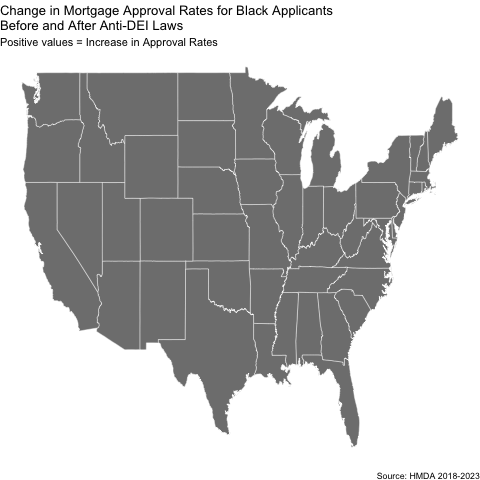

In [39]:
%%R
library(tidyverse)
library(maps)
library(viridis)

# Step 1: Approval rate change for Black applicants
approval_change <- df_clean %>%
  filter(race == "Black") %>%
  group_by(state_code, post_dei_law) %>%
  summarise(
    approval_rate = mean(approved, na.rm = TRUE),
    n = n(),
    .groups = "drop"
  ) %>%
  pivot_wider(
    names_from = post_dei_law,
    values_from = approval_rate,
    names_prefix = "post_dei_"
  ) %>%
  mutate(
    change_in_approval = post_dei_1 - post_dei_0
  )

# Step 2: Add a lookup table from state abbreviations to full names
state_lookup <- tibble(
  state_code = c("AL","AK","AZ","AR","CA","CO","CT","DE","FL","GA",
                 "HI","ID","IL","IN","IA","KS","KY","LA","ME","MD",
                 "MA","MI","MN","MS","MO","MT","NE","NV","NH","NJ",
                 "NM","NY","NC","ND","OH","OK","OR","PA","RI","SC",
                 "SD","TN","TX","UT","VT","VA","WA","WV","WI","WY"),
  state_name = tolower(c("Alabama","Alaska","Arizona","Arkansas","California","Colorado",
                  "Connecticut","Delaware","Florida","Georgia","Hawaii","Idaho",
                  "Illinois","Indiana","Iowa","Kansas","Kentucky","Louisiana",
                  "Maine","Maryland","Massachusetts","Michigan","Minnesota",
                  "Mississippi","Missouri","Montana","Nebraska","Nevada",
                  "New Hampshire","New Jersey","New Mexico","New York",
                  "North Carolina","North Dakota","Ohio","Oklahoma",
                  "Oregon","Pennsylvania","Rhode Island","South Carolina",
                  "South Dakota","Tennessee","Texas","Utah","Vermont",
                  "Virginia","Washington","West Virginia","Wisconsin","Wyoming"))
)

# Step 3: Join the full state names
approval_change <- approval_change %>%
  left_join(state_lookup, by = "state_code")

# Step 4: U.S. Map
us_states <- map_data("state")

# Step 5: Plot
ggplot() +
  geom_map(
    data = us_states, map = us_states,
    aes(x = long, y = lat, map_id = region),
    fill = "gray95", color = "white"
  ) +
  geom_map(
    data = approval_change,
    map = us_states,
    aes(map_id = state_name, fill = change_in_approval),
    color = "white", linewidth = 0.2
  ) +
  scale_fill_viridis_c(
    option = "plasma",
    name = "Approval Rate Change",
    labels = scales::percent_format(accuracy = 0.1)
  ) +
  labs(
    title = "Change in Mortgage Approval Rates for Black Applicants\nBefore and After Anti-DEI Laws",
    subtitle = "Positive values = Increase in Approval Rates",
    caption = "Source: HMDA 2018-2023",
    x = "", y = ""
  ) +
  theme_void() +
  theme(legend.position = "bottom")


In [36]:
%%R
model_black_only <- feglm(
  approved ~ post_dei_law * anti_dei_state * trump_county +
    income + loan_amount + debt_to_income |
    year + lei + county_code,
  data = df_clean %>% filter(race_group == "Black"),
  family = "binomial"
)

summary(model_black_only)


GLM estimation, family = binomial, Dep. Var.: approved
Observations: 516,176
Fixed-effects: year: 1,  lei: 2,051,  county_code: 1,856
Standard-errors: IID 
                                Estimate   Std. Error   z value  Pr(>|z|)    
anti_dei_state               2.003591274 0.8692535325   2.30496  0.021169 *  
income                       0.000037014 0.0000041522   8.91424 < 2.2e-16 ***
loan_amount                  0.000000810 0.0000000273  29.71488 < 2.2e-16 ***
debt_to_income              -0.000096282 0.0000021598 -44.57875 < 2.2e-16 ***
anti_dei_state:trump_county -1.846446594 1.1375111087  -1.62323  0.104539    
... 1 variable was removed because of collinearity (trump_county)
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
Log-Likelihood: -298,268.2   Adj. Pseudo R2: 0.047863
           BIC:  647,982.5     Squared Cor.: 0.070828


NOTES: 2,525,943 observations removed because of NA values (RHS: 2,525,943, Fixed-effects: 145,963).
       0/977/514 fixed-effects (4,231 observations) removed because of only 0 (or only 1) outcomes.
The variable 'trump_county' has been removed because of collinearity (see $collin.var).


In [30]:
%%R
model_all_logit <- feglm(
  approved ~ post_dei_law * anti_dei_state * trump_county * race + income + loan_amount + debt_to_income |
    year + lei + county_code,
  data = df_clean,
  family = "binomial"
)
summary(model_all_logit)


GLM estimation, family = binomial, Dep. Var.: approved
Observations: 563,011
Fixed-effects: year: 1,  lei: 2,213,  county_code: 2,186
Standard-errors: IID 
                                          Estimate   Std. Error    z value
anti_dei_state                         1.991297270 0.8681385665   2.293755
raceWhite                              0.052959028 0.0174815851   3.029418
income                                 0.000034897 0.0000038549   9.052733
loan_amount                            0.000000727 0.0000000259  28.034566
debt_to_income                        -0.000092745 0.0000020539 -45.155419
anti_dei_state:trump_county           -1.399469614 1.0692949759  -1.308778
anti_dei_state:raceWhite              -0.068897353 0.0499763621  -1.378599
trump_county:raceWhite                 0.005120937 0.0302771285   0.169135
anti_dei_state:trump_county:raceWhite  0.131979293 0.0674945506   1.955407
                                       Pr(>|z|)    
anti_dei_state                        0.02

NOTES: 2,765,804 observations removed because of NA values (RHS: 2,765,804, Fixed-effects: 160,313).
       0/1,025/504 fixed-effects (4,620 observations) removed because of only 0 (or only 1) outcomes.
The variable 'trump_county' has been removed because of collinearity (see $collin.var).


In [28]:
%%R
library(fixest)

model_interaction <- feglm(
  approved ~ post_dei_law * anti_dei_state * black * trump_county + income + loan_amount + debt_to_income |
    year + lei + county_code,
  data = df_clean,
  family = "binomial"
)

summary(model_interaction)


GLM estimation, family = binomial, Dep. Var.: approved
Observations: 563,011
Fixed-effects: year: 1,  lei: 2,213,  county_code: 2,186
Standard-errors: IID 
                                      Estimate   Std. Error    z value
anti_dei_state                     1.922399917 0.8694919669   2.210946
black                             -0.052959028 0.0174815851  -3.029418
income                             0.000034897 0.0000038549   9.052733
loan_amount                        0.000000727 0.0000000259  28.034566
debt_to_income                    -0.000092745 0.0000020539 -45.155419
anti_dei_state:black               0.068897353 0.0499763621   1.378599
anti_dei_state:trump_county       -1.267490321 1.0708803293  -1.183597
black:trump_county                -0.005120937 0.0302771285  -0.169135
anti_dei_state:black:trump_county -0.131979293 0.0674945506  -1.955407
                                   Pr(>|z|)    
anti_dei_state                    0.0270396 *  
black                             0.00

NOTES: 2,765,804 observations removed because of NA values (RHS: 2,765,804, Fixed-effects: 160,313).
       0/1,025/504 fixed-effects (4,620 observations) removed because of only 0 (or only 1) outcomes.
The variable 'trump_county' has been removed because of collinearity (see $collin.var).


In [32]:
# %%R
# df_with_prediction <- df_clean %>% 
#     na.omit %>% 
#     mutate (
#         prediction=predict(model_full),
#         residuals=resid(model_full),
#         residuals_z=scale(residuals)
        
#     )%>%
#     arrange(residuals)
# write.csv(df_with_prediction, 'df_with_prediction.csv')


In [60]:
%%R
summary(model_black)

OLS estimation, Dep. Var.: approved
Observations: 2,900,294
Fixed-effects: activity_year: 6,  county_code: 2,962
Standard-errors: Clustered (activity_year) 
                          Estimate   Std. Error   t value   Pr(>|t|)    
post_dei_law         -0.0010498930 5.153188e-03 -0.203737 8.4659e-01    
anti_dei_state        0.1618609489 5.359695e-02  3.019966 2.9418e-02 *  
income                0.0000028332 2.247800e-07 12.604544 5.5824e-05 ***
loan_amount           0.0000000134 5.640000e-09  2.377879 6.3331e-02 .  
debt_to_income       -0.0000007375 3.101000e-07 -2.378364 6.3293e-02 .  
post_dei_law:black   -0.0000000462 1.827000e-08 -2.528512 5.2625e-02 .  
anti_dei_state:black  0.0000005168 7.602000e-08  6.798480 1.0483e-03 ** 
... 3 variables were removed because of collinearity (black, post_dei_law:anti_dei_state and post_dei_law:anti_dei_state:black)
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
RMSE: 0.460527     Adj. R2: 0.009115
                 Within R2:

In [68]:
%%R
df_clean %>%
  group_by(activity_year, race, anti_dei_state) %>%
  summarise(approval_rate = mean(approved)) %>%
  ggplot(aes(x = activity_year, y = approval_rate, color = race, linetype = as.factor(anti_dei_state))) +
  geom_line() +
  labs(title = "Approval Trends Over Time by Race and DEI Policy")
ggsave(
  filename = "approval_trends_all_states.png",
  width = 14,              
  height = 10,            
  dpi = 600
)



`summarise()` has grouped output by 'activity_year', 'race'. You can override
using the `.groups` argument.


In [63]:
%%R
df_clean %>%
  group_by(activity_year, race, anti_dei_state, state_code) %>%
  summarise(approval_rate = mean(approved, na.rm = TRUE)) %>%
  ggplot(aes(x = activity_year, y = approval_rate, color = race, linetype = as.factor(anti_dei_state))) +
  geom_line() +
  facet_wrap(~ state_code) +
  labs(
    title = "Approval Trends Over Time by Race and DEI Policy",
    x = "Year",
    y = "Approval Rate",
    linetype = "Anti-DEI State",
    color = "Race"
  ) +
  theme_minimal()
# Save 
ggsave(
  filename = "approval_trends_by_state.png",
  width = 14,              
  height = 10,            
  dpi = 600
)


`summarise()` has grouped output by 'activity_year', 'race', 'anti_dei_state'.
You can override using the `.groups` argument.


In [64]:
%%R

# Identify anti-DEI states
anti_dei_states <- df_clean %>%
  filter(anti_dei_state == 1) %>%
  distinct(state_code) %>%
  pull(state_code)

# Create a named vector for facet labels
state_labels <- df_clean %>%
  distinct(state_code) %>%
  mutate(label = if_else(state_code %in% anti_dei_states,
                         paste0(state_code, " *"),
                         state_code)) %>%
  deframe()


In [71]:
%%R
df_clean %>%
  group_by(activity_year, race, anti_dei_state, state_code) %>%
  summarise(approval_rate = mean(approved, na.rm = TRUE), .groups = "drop") %>%
  ggplot(aes(x = activity_year, y = approval_rate, color = race, linetype = as.factor(anti_dei_state))) +
  geom_line() +
  facet_wrap(~ state_code, labeller = labeller(state_code = state_labels), scales = 'free') +
  labs(
    title = "Approval Trends Over Time by Race and DEI Policy",
    x = "Year",
    y = "Approval Rate",
    linetype = "Anti-DEI State",
    color = "Race"
  ) +
  theme_minimal()
ggsave(
  filename = "approval_trends_by_state*.png",
  width = 14,              
  height = 10,            
  dpi = 600
)
